In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy as sp
import scipy.stats as stats

import sys

%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    #cov = np.cov(points)

    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2.0* nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [3]:
#Get Planck data
data = pd.read_csv('./total_data_withlensing.csv')
#data = pd.read_csv('./total_data_TT.csv')

reducedata = data[0::1]

In [4]:
#Estimate normalized Planck posterior on (Omega_m,sigma_8) from 2D histogram
nbins=50

hist, omega_edges, sigma_edges = np.histogram2d(reducedata['omegam'],reducedata['sigma8'],
                                                bins=nbins, normed=True,
                                               weights=reducedata['weight'])

def planck_posterior(sigma8,omegam):
    #Find the bin that (sigma8,omegam) falls into
    sig_loc = np.searchsorted(sigma_edges,sigma8)
    omeg_loc = np.searchsorted(omega_edges,omegam)
    
    try:
        #post = hist[sig_loc-1,omeg_loc-1]
        post = hist[omeg_loc-1,sig_loc-1]

    except:
        post = 0.0

    return post

In [19]:
#Define the cluster likelihood function.  Doesn't require it to be normalized.

#From Michelle
#log of Data likelihood (unnormalized)
#i.e., like_grid = \chi^2 + const
    
#like_grid = np.load('./michelle_data/L_VDF_unscaled.npy')
#like_grid = np.load('./michelle_data/L_MDF_ML1pred.npy')
#like_grid = np.load('./michelle_data/L_MDF_Mtot.npy')
#like_grid = np.load('./michelle_data/L_MDF_PL1pred.npy')
#like_grid = np.load('./michelle_data/L_VDF_unscaled_witherr.npy')
#like_grid = np.load('./michelle_data/L_VDF_scaled.npy')
#like_grid = np.load('./michelle_data/L_VDF_scaled_witherr.npy')

#like_grid = np.load('./michelle_data/new_data/L_MDF_ML1pred.npy')
#like_grid = np.load('./michelle_data/new_data/L_MDF_Mtot.npy')
#like_grid = np.load('./michelle_data/new_data/L_MDF_PL1pred.npy')
#like_grid = np.load('./michelle_data/new_data/L_VDF_scaled_witherr.npy')
#like_grid = np.load('./michelle_data/new_data/L_VDF_unscaled.npy')
#like_grid = np.load('./michelle_data/new_data/L_VDF_unscaled_witherr.npy')

#like_grid = np.load('./michelle_data/new_data2/L_MDF_ML1pred.npy')
#like_grid = np.load('./michelle_data/new_data2/L_MDF_Mtot.npy')
#like_grid = np.load('./michelle_data/new_data2/L_MDF_PL1pred.npy')
#like_grid = np.load('./michelle_data/new_data2/L_VDF_unscaled.npy')
#like_grid = np.load('./michelle_data/new_data2/L_VDF_unscaled_witherr.npy')
#like_grid = np.load('./michelle_data/new_data2/L_VDF_scaled_witherr.npy')


def make_likelihood(like_grid, fdirectory):

    #like_grid[i,j] = L(sig_list[i], om_list[j])
    #sig_list = np.loadtxt('./michelle_data/sigma_list.txt')
    #om_list = np.loadtxt('./michelle_data/omega_list.txt')
    #sig_list = np.loadtxt('./michelle_data/sigma_list2.txt')
    #om_list = np.loadtxt('./michelle_data/omega_list2.txt')
    #sig_list = np.loadtxt('./michelle_data/sigma_list3.txt')
    #om_list = np.loadtxt('./michelle_data/omega_list3.txt')
    
    if '100' in fdirectory or '50' in fdirectory:
        sig_list = np.loadtxt('./michelle_data/sigma_list5.txt')
        om_list = np.loadtxt('./michelle_data/omega_list5.txt')
    else:
        sig_list = np.loadtxt('./michelle_data/sigma_list4.txt')
        om_list = np.loadtxt('./michelle_data/omega_list4.txt')
    
    print like_grid.shape[0], like_grid.shape[1]

    #interp_function = interp.interp2d(sig_list,om_list,like_grid.T, kind='cubic')
    interp_function = interp.interp2d(om_list,sig_list,like_grid, kind='cubic')

    def mich_likelihood_interp(sigma8, omegam):
        return np.array(np.max([interp_function(omegam, sigma8),[0.0]]) )

    def mich_likelihood(sigma8, omegam):
        sig_loc = np.searchsorted(sig_list,sigma8)
        om_loc = np.searchsorted(om_list, omegam)

        small = 1e-9
        big = 1e9

        dsig_1 = sigma8-sig_list[sig_loc]
        try:
            dsig_2 = sigma8-sig_list[sig_loc+1]
        except:
            dsig_2 = big

        dom_1 = omegam - om_list[om_loc]
        try:
            dom_2 = omegam - om_list[om_loc+1]
        except:
            dom_2 = big

        dist1 = np.sqrt(dsig_1**2 + dom_1**2)
        dist2 = np.sqrt(dsig_1**2 + dom_2**2)
        dist3 = np.sqrt(dsig_2**2 + dom_1**2)
        dist4 = np.sqrt(dsig_2**2 + dom_2**2)
        dist_renorm = 1.0/dist1+1.0/dist2+1.0/dist3+1.0/dist4

        dist1 = 1.0/dist1/dist_renorm
        dist2 = 1.0/dist2/dist_renorm
        dist3 = 1.0/dist3/dist_renorm
        dist4 = 1.0/dist4/dist_renorm


        like1 = like_grid[sig_loc,om_loc]*dist1
        like2 = like_grid[sig_loc,om_loc+1]*dist2
        like3 = like_grid[sig_loc+1,om_loc]*dist3
        like4 = like_grid[sig_loc+1,om_loc+1]*dist4

        loglike = like1 + like2 + like3 + like4

        return loglike


    def test_mich_likelihood(sigma8,omegam):


        omegam_0 = 0.675
        #sigma8_0 = 0.75
        sigma8_0 = 0.785
        slope=0.5

        var = 0.00015

        f = slope*(omegam - omegam_0)**2 + sigma8_0

        d = sigma8 - f

        loglike = - d**2/2.0/var

        #Not normalized
        return np.exp(loglike)

    def test_mich_likelihood2(sigma8,omegam):
        x=[sigma8, omegam]
        mean = [0.85,0.34]
        var = [0.0001,0.0001]

        chi2 = (1.0/var[0])*(sigma8 - mean[0])**2 + (1.0/var[1])*(omegam - mean[1])**2

        return np.exp(-chi2)

    def test_mich_likelihood3(sigma8,omegam):
        return 1.0

    #return mich_likelihood
    return mich_likelihood_interp
    #return test_mich_likelihood2
    
def joint_posterior(omegam,sigma8, new_hist, new_xedges, new_yedges):

    #Find the bin that (sigma8,omegam) falls into
    sig_loc = np.searchsorted(new_yedges,sigma8)
    omeg_loc = np.searchsorted(new_xedges,omegam)

    try:
        #post = new_hist[sig_loc-1,omeg_loc-1]
        post = new_hist[omeg_loc-1,sig_loc-1]

    except:
        post = 0.0

    return np.array(post)

def run(fileroot,directory):
    
    like_grid = np.load(directory+fileroot+".npy")

    mich_likelihood = make_likelihood(like_grid, directory)
    
    #Reweight the Planck sample so that it is the normalized, combined posterior P(Omega_m, sigma_8 | D_cluster, D_cmb)

    #Get the unnormalized combined cluster and Planck posterior
    unnorm_combined_prob = []

    nsamples=10000
    #test_om = np.random.uniform(np.min(reducedata['omegam']),np.max(reducedata['omegam']),nsamples)
    #test_sig = np.random.uniform(np.min(reducedata['sigma8']),np.max(reducedata['sigma8']),nsamples)

    #test_sig = np.random.uniform(0.78,0.89,nsamples)
    #test_om = np.random.uniform(0.28,0.35,nsamples)

    test_sig = np.random.uniform(0.78,0.92,nsamples)
    test_om = np.random.uniform(0.26,0.37,nsamples)

    #for om, sig in zip(reducedata['omegam'],reducedata['sigma8']):
    for om, sig in zip(test_om,test_sig):
        newprob = mich_likelihood(sig, om)*planck_posterior(sig, om) #Combined posterior, unnormed
        unnorm_combined_prob.append(newprob)
    
    unnorm_combined_prob = np.array(unnorm_combined_prob)

    #Normalize it
    #int_unnorm_post = 0.0
    #for om, sig in zip(reducedata['omegam'],reducedata['sigma8']):
    #    int_unnorm_post += mich_likelihood(sig,om)
    #int_unnorm_post = int_unnorm_post/len(reducedata['omegam'])
    #norm_factor = 1.0/int_unnorm_post
    #normed_combined_prob = norm_factor*unnorm_combined_prob

    #Get a function for the joint posterior by histogram estimation
    bins=50

    new_hist, new_xedges, new_yedges = np.histogram2d(test_om,test_sig, bins=bins,
                                                  weights=unnorm_combined_prob, normed=True)

    #new_hist, new_xedges, new_yedges = np.histogram2d(reducedata['omegam'],reducedata['sigma8'], bins=bins,
#                                                  #weights=normed_combined_prob[:,0], normed=True)
#                                                  #weights=normed_combined_prob, normed=True)
#                                                  weights=unnorm_combined_prob, normed=True)
#
#                                                  #normed=True)

    
    #sig_list = np.loadtxt('sigma_list.txt')
    #om_list = np.loadtxt('omega_list.txt')

    sig_list = np.linspace(0.76,0.90,150)
    om_list = np.linspace(0.26,0.35,150)


    #newL = sp.zeros((len(sig_list), len(om_list)))
    newL = sp.zeros((len(om_list), len(sig_list)))
    planckL = sp.zeros((len(om_list), len(sig_list)))

    for sig, sig_loc in zip(sig_list,xrange(len(sig_list))):
        for om, om_loc in zip(om_list,xrange(len(om_list))):
            newL[sig_loc, om_loc] = joint_posterior(om, sig, new_hist, new_xedges, new_yedges)
            #newL[om_loc, sig_loc] = joint_posterior(om, sig, new_hist, new_xedges, new_yedges)

            planckL[sig_loc, om_loc] = planck_posterior(sig,om)
        
    #newL.dump('newL.npy')
    #sig_list.dump('newsig_list.npy')
    #om_list.dump('newom_list.npy')

    #print newL
    
    def metro_hastings(dist):
        std = np.std(reducedata['sigma8'])
        def prop_dist(point):
            new_point = np.random.normal(point,std)
            return new_point
    
        def next_chain_element(point, new_point):
            p1 = dist(point)
            p2 = dist(new_point)
            accept = np.random.uniform()
            if accept < p2/p1:
                return new_point
            else:
                return point
        
        #seed_point = np.array([0.31,0.815])
        #seed_point = np.array([0.815,0.31])
        rand_choice = np.random.choice(xrange(len(reducedata)))
        seed_point = np.array(reducedata[['omegam','sigma8']].loc[[rand_choice]])[0]

        chain = [seed_point]
    
        nsteps = 50000
        for step in xrange(nsteps):
            point = chain[step]
            new_point = prop_dist(point)
            chain.append(next_chain_element(point,new_point))
    
        burnin= 1000

        return np.array(chain[burnin::])

    def test_joint_posterior(point):
        sig=point[1]
        om=point[0]
        return joint_posterior(om,sig,new_hist, new_xedges, new_yedges)
    
    sample = metro_hastings(test_joint_posterior)


    pos = sample.mean(axis=0)
    cov = np.cov(sample, rowvar=False)

    pos.dump(directory+'mean_'+fileroot+'.npy')
    cov.dump(directory+'cov_'+fileroot+'.npy')
    
    #print pos
    #print cov

    #plt.scatter(sample[:,1],sample[:,0],  s=40, edgecolor='')
    
    planck_sample=np.array(reducedata[['omegam','sigma8']])

    plt.imshow(new_hist, interpolation='nearest', origin='low',
                extent=[new_xedges[0], new_xedges[-1], new_yedges[0], new_yedges[-1]],
          cmap='afmhot')


    #plot_point_cov(planck_sample, nstd=2, alpha=0.75, color='brown')

    plt.xlim([0.20,0.40])
    plt.ylim([0.70,1.0])

    #plt.xlim([0.26,0.36])
    #plt.ylim([0.79,0.88])
    

    #plot_point_cov(sample, nstd=2, alpha=0.25, color='blue')



    #plt.scatter(planck_sample[:,0],planck_sample[:,1])

    #plt.scatter(0.316,0.831,c='r')
    
    planck_pos = planck_sample.mean(axis=0)
    planck_cov = np.cov(planck_sample, rowvar=False)

    planck_pos.dump(directory+'planck_mean.npy')
    planck_cov.dump(directory+'planck_cov.npy')
    
    
    
    
    
    
    #like_grid = np.load('./michelle_data/L_VDF_unscaled.npy')
    #like_grid = np.load('./michelle_data/L_MDF_Mtot.npy')

    #plt.imshow(like_grid, interpolation = 'nearest',origin = 'low',
    #           extent=[0.2, 0.4, 0.6, 1.0],
    #          cmap='afmhot')

    nsamples = 20000
    test_x = np.random.uniform(0.25,0.35,nsamples)
    test_y = np.random.uniform(0.78,0.92,nsamples)
    test_z = map(lambda z: mich_likelihood(*z),zip(test_y,test_x))

    plt.scatter(test_x, test_y, c= test_z, s=40, alpha=0.25, edgecolor='', cmap='afmhot')

    plot_point_cov(planck_sample, nstd=2, alpha=0.5, color='blue')
    plot_point_cov(sample, nstd=2, alpha=0.5, color='red')

    plt.scatter(0.307,0.823,c='g',s=60)

    #plt.scatter(test_om, test_sig, c=unnorm_combined_prob)


    plt.ylim([0.78,0.92])
    plt.xlim([0.25,0.35])
    
    


/Users/laynep/Dropbox/VDF_constraints/R100/
L_MDF_Mtot
26 17
L_VDF_unscaled_richness
26 17
L_MDF_PL1pred
26 17
L_VDF_unscaled_richness_witherr
26 17
L_VDF_unscaled
26 17
L_VDF_unscaled_witherr
26 17
/Users/laynep/Dropbox/VDF_constraints/R50/
L_MDF_Mtot
26 17
L_VDF_unscaled_richness
26 17
L_MDF_PL1pred
26 17
L_VDF_unscaled_richness_witherr
26 17
L_VDF_unscaled
26 17
L_VDF_unscaled_witherr
26 17
/Users/laynep/Dropbox/VDF_constraints/R200/
L_MDF_Mtot
42 27
L_VDF_unscaled_richness
42 27
L_MDF_PL1pred
42 27
L_VDF_unscaled_richness_witherr
42 27
L_VDF_unscaled
42 27
L_VDF_unscaled_witherr
42 27


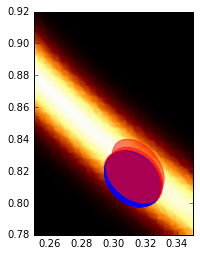

In [21]:
#directories =map(lambda x: "/Users/laynep/Dropbox_Gmail/Dropbox/VDF_constraints/"+x,['100/','200/','400/','50/','800/'])
#fileroots = ['L_MDF_Mtot','L_MDF_PL1pred','L_VDF_unscaled','L_VDF_unscaled_richness','L_VDF_unscaled_richness_witherr','L_VDF_unscaled_witherr']
#fileroots = ['L_VDF_unscaled_richness_witherr','L_VDF_unscaled_witherr']
#fileroots= ['L_MDF_Mtot']
#fileroots= ['L_VDF_unscaled']
#fileroots= ['L_MDF_PL1pred']
#fileroots= ['L_VDF_unscaled_witherr']


#directories =map(lambda x: "/Users/laynep/Dropbox/VDF_constraints/"+x,['z=0.5/'])

#directories =map(lambda x: "/Users/laynep/Dropbox/VDF_constraints/"+x,['50/','100/','200/'])
#fileroots = ['L_VDF_unscaled','L_VDF_unscaled_witherr']
#fileroots = ['L_VDF_unscaled_witherr']

directory_root = "/Users/laynep/Dropbox/VDF_constraints/"
directories = map(lambda x: directory_root + x, 
                  #['Q200/','R100/','R50/','Q100/','Q50/','R200/'])
                  #['Q200/','Q100/','Q50/'])
                  ['R100/','R50/','R200/'])

fileroots = ['L_MDF_Mtot','L_VDF_unscaled_richness','L_MDF_PL1pred',
             'L_VDF_unscaled_richness_witherr','L_VDF_unscaled',
             'L_VDF_unscaled_witherr']


for direct in directories:
    print direct
    for root in fileroots:
        print root
        run(root,direct)

#run(fileroot,directory)


In [ ]:
#H, xedges, yedges = np.histogram2d(reducedata['omegam'],reducedata['sigma8'], bins=nbins, normed=True)


#plt.imshow(H, interpolation='nearest', origin='low',
#                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#          cmap='afmhot')

#plot_point_cov(planck_sample, nstd=2, alpha=0.25, color='blue')



#plt.scatter(0.307,0.823,c='r')

#plt.scatter( np.mean(planck_sample[:,0]), np.mean(planck_sample[:,1]), c='b')
#plt.scatter( np.mean(reducedata['omegam']), np.mean(reducedata['sigma8']), c='r')

In [ ]:
#like_grid = np.load('./michelle_data/L_VDF_unscaled.npy')
#like_grid = np.load('./michelle_data/L_MDF_Mtot.npy')

#plt.imshow(like_grid, interpolation = 'nearest',origin = 'low',
#           extent=[0.2, 0.4, 0.6, 1.0],
#          cmap='afmhot')

nsamples = 20000
test_x = np.random.uniform(0.25,0.35,nsamples)
test_y = np.random.uniform(0.78,0.92,nsamples)
test_z = map(lambda z: mich_likelihood(*z),zip(test_y,test_x))

plt.scatter(test_x, test_y, c= test_z, s=40, alpha=0.25, edgecolor='', cmap='afmhot')

plot_point_cov(planck_sample, nstd=2, alpha=0.5, color='blue')
plot_point_cov(sample, nstd=2, alpha=0.5, color='red')

plt.scatter(0.307,0.823,c='g',s=60)

#plt.scatter(test_om, test_sig, c=unnorm_combined_prob)


plt.ylim([0.78,0.92])
plt.xlim([0.25,0.35])